<a href="https://colab.research.google.com/github/kaniarasann/Langchain/blob/main/08_Evaluvator_Pattern.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
#!pip install langchain langgraph langchain_groq pydantic

In [68]:
from typing import Annotated, List,Literal
from pydantic import BaseModel, Field
import operator
from langchain_groq import ChatGroq
from langchain_core.prompts import PromptTemplate
from langgraph.constants import Send
from langgraph.graph import StateGraph, START, END
from langchain_groq import ChatGroq
from google.colab import userdata
groq_key = userdata.get('groq_key')

In [69]:
llm = ChatGroq(api_key=groq_key, model="llama-3.3-70b-versatile",)

In [70]:
class State(BaseModel):
  topic : str = ""
  joke : str = ""
  feedback: Annotated[List[str],operator.add] =[]
  is_funny: bool = True

class JokeEvaluvator(BaseModel):
  joke:str
  is_funny:bool
  topic:str



In [71]:
llm_joke = llm.with_structured_output(JokeEvaluvator)

In [72]:
def llm_call(state:State):
  if len(state.feedback) == 0 :
     prompts = PromptTemplate.from_template("Generate a Joke for the topic:{topic}").format(topic = state.topic)
     formated_prompts=prompts.format(topic = state.topic)
  else:
     feedback =". ".join(state.feedback)
     prompts = PromptTemplate.from_template("Generate a Joke for the topic {topic}. consider the following feednack while generating the Joke:{feedback}  ")
     formated_prompts=prompts.format(topic =state.topic,feedback= feedback)

  res = llm.invoke(formated_prompts)

  return {"joke":res.content}



In [73]:
class relevance_response(BaseModel):
  is_relavant:Literal["Yes","No"]

llm_relevance = llm.with_structured_output(relevance_response)

class humor_response(BaseModel):
  humor_score:int

llm_humor = llm.with_structured_output(humor_response)

class clarity_response(BaseModel):
  is_clarity:Literal["Yes","No"]

llm_clarity = llm.with_structured_output(clarity_response)

class offensive_response(BaseModel):
  is_offensive:Literal["Yes","No"]

llm_offensive = llm.with_structured_output(offensive_response)


def evaluvator (state:State):
    results = {}
    relevance_prompt = PromptTemplate.from_template(
        "Given the topic: '{topic}', is the following joke relevant to it? Answer 'Yes' or 'No'.\n\nJoke: {joke}"
    )
    results["relevance"] = llm_relevance.invoke(relevance_prompt.format(topic=state.topic, joke=state.joke))

    # 2. Humor Quality
    humor_prompt = PromptTemplate.from_template(
        "Rate the humor of the following joke on a scale from 1 (not funny) to 5 (very funny).Answer between 1 to 5:\n\n{joke}"
    )
    results["humor_score"] = llm_humor.invoke(humor_prompt.format(joke=state.joke))

    # 3. Clarity and Structure
    clarity_prompt = PromptTemplate.from_template(
        "Is the following joke grammatically correct and easy to understand? Answer 'Yes' or 'No'.\n\n{joke}"
    )
    results["clarity"] = llm_clarity.invoke(clarity_prompt.format(joke=state.joke))

    # 4. Offensiveness Check
    offensive_prompt = PromptTemplate.from_template(
        "Does this joke contain any offensive or inappropriate content? Answer 'Yes' or 'No'.\n\n{joke}"
    )
    results["offensive"] = llm_offensive.invoke(offensive_prompt.format(joke=state.joke))

    if(results['relevance'].is_relavant != "Yes"):
      return {"is_funny":False,"feedback": ["The Joke is not relavant to the topic"]}
    elif(results['humor_score'].humor_score <3):
      return {"is_funny":False,"feedback": ["The Joke is not funny"]}
    elif(results['clarity'].is_clarity!= "Yes"):
      return {"is_funny":False,"feedback": ["The Joke is not grammatically correct"]}
    elif(results['offensive'].is_offensive!= "No"):
      return {"is_funny":False,"feedback": ["The Joke contains offensive content"]}
    else:
      return {"is_funny":True}



In [74]:
def add_condtional_routing(state:State):
  if(state.is_funny):
    return "Accepted"
  else:
    return "Rejected"

In [75]:
graph = StateGraph(State)
graph.add_node("llm_call", llm_call)
graph.add_node("evaluvator", evaluvator)

graph.add_edge(START,"llm_call")
graph.add_edge("llm_call","evaluvator")
graph.add_conditional_edges("evaluvator",add_condtional_routing,{"Accepted":END,"Rejected":"llm_call"})

builder = graph.compile()


In [76]:
from IPython.display import display, Image
from pydantic import BaseModel

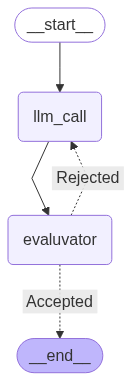

In [77]:
display(Image(builder.get_graph().draw_mermaid_png()))


In [78]:
for event in builder.stream(State(topic="Joke on AI")):
    print(event)

{'llm_call': {'joke': 'Why did the AI program go to therapy?\n\nBecause it was struggling to process its emotions and was feeling a little "glitchy"! But in the end, it just needed to reboot its mindset and update its attitude!'}}
{'evaluvator': {'is_funny': True}}


In [79]:
    relevance_prompt = PromptTemplate.from_template(
        "Given the topic: '{topic}', is the following joke relevant to it? Answer 'Yes' or 'No'.\n\nJoke: {joke}"
    )
    res = llm_relevance.invoke(relevance_prompt.format(topic="Joke on AI", joke='Why did the AI program go on a diet?\n\nBecause it wanted to lose some bytes!'))

In [80]:
res.is_relavant


'Yes'